## Simulated Data Generating Process (DGP)

Sensor n° 1, 2, and 3

For $t<T_1$:

* y_1 ~ N(mu_1, sigma_1)
* y_2 ~ N(mu_2, sigma_2)
* y_3 ~ N(mu_3, sigma_3)

For $t>=T_1$:

* y_1 ~ N(mu_11, sigma_1) -> Mean Drift!
* y_2 ~ N(mu_2, sigma_2)
* y_3 ~ N(mu_3, sigma_3)

For $t>=T_2$:

* y_1 ~ N(mu_11, sigma_1) -> Mean Drift (started at $T_1$)
* y_2 ~ N(mu_2, sigma_2)
* y_3 ~ N(mu_33, sigma_3) -> Mean Drift!


In [1]:
from kafka import KafkaProducer
import time
import json
import numpy as np
import random

In [2]:
from dataclasses import dataclass

@dataclass
class DriftParams:
    t0_drift:int = None
    mu_drift:float = None
    delta_drift:int = None


@dataclass
class SensorParams:
    sensor_name: str
    mu: float
    sigma: float
    eps: float
    delay_mode: str  # "fix" or "random"
    delay_value: float
    max_delay: float = None  # Optional for "random" delay mode
    drifts:list = None
    

In [3]:
drift_events_sens_1 = [{"drift-event": DriftParams(t0_drift = 1, 
                                                   mu_drift =2, 
                                                   delta_drift=3)},
                        {"drift-event": DriftParams(t0_drift = 7, 
                                                    mu_drift =2, 
                                                    delta_drift=2)}]

drift_events_sens_3 = [{"drift-event": DriftParams(t0_drift = 0, 
                                                   mu_drift =5, 
                                                   delta_drift=5)},
                        {"drift-event": DriftParams(t0_drift = 10, 
                                                    mu_drift =2, 
                                                    delta_drift=2)}]


In [4]:
# Configurations
SEED=42
i=0
streaming_duration=15

params_sens1 = SensorParams(sensor_name="sensor-1",
                            mu=2,
                            sigma=5,
                            eps=0.2,
                            delay_mode="fix",
                            delay_value=1,
                            max_delay=5,
                            drifts=drift_events_sens_1
                            )

params_sens2 = SensorParams(sensor_name="sensor-2",
                            mu=3.5,
                            sigma=3.2,
                            eps=0.3,
                            delay_mode="fix",
                            delay_value=1,
                            max_delay=5
                            )

params_sens3 = SensorParams(sensor_name="sensor-3",
                            mu=1,
                            sigma=2.2,
                            eps=0.25,
                            delay_mode="fix",
                            delay_value=1,
                            max_delay=5,
                            drifts=drift_events_sens_3
                            )

In [5]:
def set_sensor_delay(params:SensorParams):
    """
    Set sensor delay either fix or random mode
    Args:
        params (SensorParams): Parameters for the sensor data generation.
    """
    if params.delay_mode == "fix":
        time.sleep(params.delay_value)
    elif params.delay_mode == "random":
        if params.max_delay is None:
            raise ValueError("max_delay should be specified in delay_mode 'random'")
        time.sleep(random.uniform(params.delay_value, params.max_delay))
    else:
        raise ValueError("delay_mode should be 'fix' or 'random'")

In [6]:
def send_sensor_data(producer: KafkaProducer, topic: str, params: SensorParams, time_step: int) -> tuple:
    """Send sensor data to Kafka topic with specified parameters.
    Args:
        producer (KafkaProducer): Kafka producer instance.
        topic (str): Kafka topic to send data to.
        params (SensorParams): Parameters for the sensor data generation.
        time_step (int): Time step
    Returns:
        tuple: Generated data value and the time taken to send the data.
    """
    start_time=time.time()
    noise= params.eps * np.random.normal(0, 1)
    drift = False
    data_value = np.random.normal(params.mu, params.sigma) + noise

    if params.drifts:
        for i, drift_event in enumerate(params.drifts):
            t0 = drift_event['drift-event'].t0_drift
            delta = drift_event['drift-event'].delta_drift
            if t0 <= time_step <= t0 + delta:
                mu_drift = drift_event['drift-event'].mu_drift
                data_value = np.random.normal(mu_drift, params.sigma) + noise
                drift = True
                break
        
    data_sent={'sensor': params.sensor_name,
               'info': {'obs': data_value,
                        'drift': drift}}
    try:
        producer.send(topic, value=data_sent)
    except Exception as e:
        print(f"Error sending data to Kafka: {e}")

    set_sensor_delay(params)
        
    end_time=time.time() - start_time
    
    return data_value, drift, end_time

In [7]:
producer = KafkaProducer(bootstrap_servers='localhost:9092', 
                         value_serializer=lambda v: json.dumps(v).encode('utf-8'))

In [8]:
np.random.seed(SEED)

list_sensobs_1 = []
list_drifts_1=[]
list_delay_1 = []

list_sensobs_2 = []
list_drifts_2=[]
list_delay_2 = []

list_sensobs_3 = []
list_drifts_3=[]
list_delay_3 = []

for i in range(streaming_duration):

    print("--"*20)
    print(f"Time step {i}")
    print(" ")
    
    # Sensor-1
    data_1, \
        drift_1,\
            delay_1 = send_sensor_data(producer=producer,
                                           topic="sensors",
                                           params=params_sens1,
                                           time_step=i)
    # Sensor-2
    data_2, \
        drift_2,\
            delay_2 = send_sensor_data(producer=producer,
                                           topic="sensors",
                                           params=params_sens2,
                                           time_step=i)
    # Sensor-3
    data_3, \
        drift_3,\
            delay_3 = send_sensor_data(producer=producer,
                                           topic="sensors",
                                           params=params_sens3,
                                           time_step=i)

    list_sensobs_1.append(data_1)
    list_drifts_1.append(drift_1)
    list_delay_1.append(delay_1)

    list_sensobs_2.append(data_2)
    list_drifts_2.append(drift_2)
    list_delay_2.append(delay_2)

    list_sensobs_3.append(data_3)
    list_drifts_3.append(drift_3)
    list_delay_3.append(delay_3)

    print(f"[sensor-1] Obs: {round(data_1,3)}, Drift: {drift_1}, Delay: {round(delay_1,3)}")
    print(f"[sensor-2] Obs: {round(data_2,3)}, Drift: {drift_2}, Delay: {round(delay_2,3)}")
    print(f"[sensor-3] Obs: {round(data_3,3)}, Drift: {drift_3}, Delay: {round(delay_3,3)}")
    print(" ")
    print(f"Total Delay: {delay_1 + delay_2 + delay_3}")

----------------------------------------
Time step 0
 
[sensor-1] Obs: 1.408, Drift: False, Delay: 1.108
[sensor-2] Obs: 8.568, Drift: False, Delay: 1.005
[sensor-3] Obs: 8.416, Drift: True, Delay: 1.001
 
Total Delay: 3.1136960983276367
----------------------------------------
Time step 1
 
[sensor-1] Obs: 4.866, Drift: True, Delay: 1.002
[sensor-2] Obs: 1.871, Drift: False, Delay: 1.002
[sensor-3] Obs: 1.266, Drift: True, Delay: 1.002
 
Total Delay: 3.0056984424591064
----------------------------------------
Time step 2
 
[sensor-1] Obs: 3.459, Drift: True, Delay: 1.003
[sensor-2] Obs: -1.292, Drift: False, Delay: 1.004
[sensor-3] Obs: 5.515, Drift: True, Delay: 1.005
 
Total Delay: 3.0116186141967773
----------------------------------------
Time step 3
 
[sensor-1] Obs: 2.27, Drift: True, Delay: 1.005
[sensor-2] Obs: 4.357, Drift: False, Delay: 1.002
[sensor-3] Obs: 3.526, Drift: True, Delay: 1.005
 
Total Delay: 3.012615203857422
----------------------------------------
Time step 4

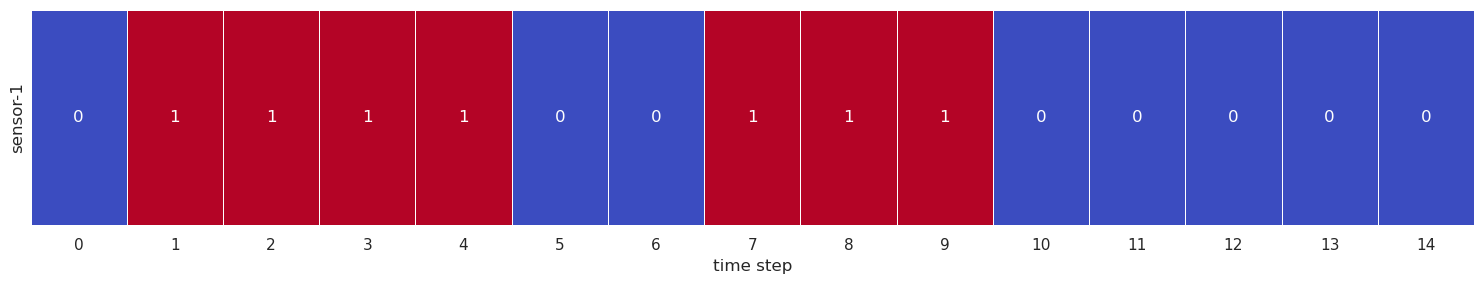

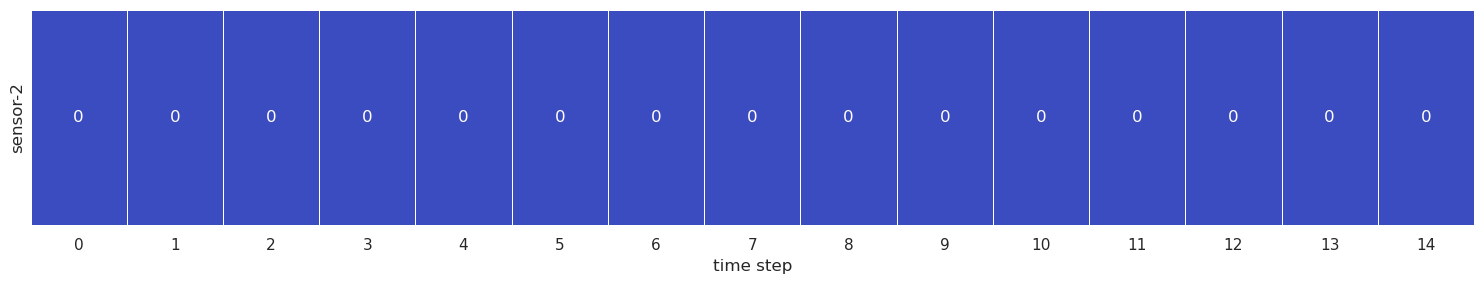

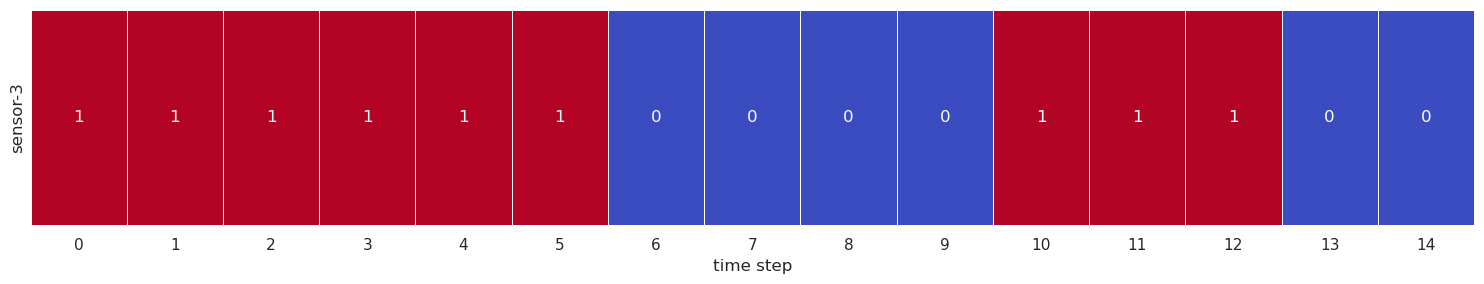

In [9]:
# Heatmap of drifts list
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(15, 3))
sns.heatmap(np.array(list_drifts_1).reshape(-1,1).T, 
            cmap="coolwarm", cbar=False, linewidths=0.5, linecolor='white', annot=True, yticklabels=False, label="sensor-1")
plt.xlabel("time step")
plt.ylabel("sensor-1")
plt.tight_layout()
plt.show()

sns.set(style="whitegrid")
plt.figure(figsize=(15, 3))
sns.heatmap(np.array(list_drifts_2).reshape(-1,1).T, 
            cmap="coolwarm", cbar=False, linewidths=0.5, linecolor='white', annot=True, yticklabels=False, label="sensor-2")
plt.xlabel("time step")
plt.ylabel("sensor-2")
plt.tight_layout()
plt.show()

sns.set(style="whitegrid")
plt.figure(figsize=(15, 3))
sns.heatmap(np.array(list_drifts_3).reshape(-1,1).T, 
            cmap="coolwarm", cbar=False, linewidths=0.5, linecolor='white', annot=True, yticklabels=False, label="sensor-2")
plt.xlabel("time step")
plt.ylabel("sensor-3")
plt.tight_layout()
plt.show()

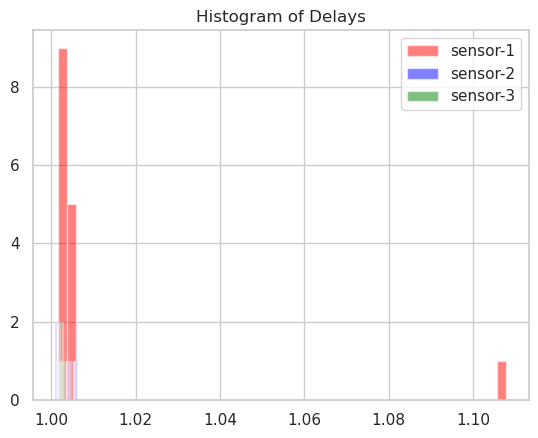

In [10]:
import matplotlib.pyplot as plt

plt.hist(list_delay_1, alpha=0.5, label="sensor-1", color="red", bins=50)
plt.hist(list_delay_2, alpha=0.5, label="sensor-2", color="blue", bins=50)
plt.hist(list_delay_3, alpha=0.5, label="sensor-3", color="green", bins=50)
plt.title("Histogram of Delays")
plt.legend()
plt.show()